In [1]:
### Import necessary libraries & packages ###
import os
import tensorflow as tf
os.environ['KERAS_BACKEND'] = 'tensorflow'

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import svm
import xgboost as xgb


import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.metrics import roc_curve, roc_auc_score, precision_score, accuracy_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn import metrics
# Our custom functions #
#%run clf_functions.ipynb

from nltk import word_tokenize
from gensim.models import word2vec

Using TensorFlow backend.


GloVe - Global Vector for Word Representation from Stanford NLP Group. This file containes pre-trained word vectors for 6 billion words and phrases.

In [2]:
#unzip the glove.
from zipfile import ZipFile
ZipFile("glove.6B.50d.txt.zip").extractall("")

In [3]:
#load the data and turn it into a dataframe.
df = pd.read_csv('dataset_dichot.csv')
print(len(df))
df.head()

3539


,Brand,Sentiment,Clean_tweet
0,iPad or iPhone App,4,know awesom ipadiphon app like appreci design ...
1,iPad,4,not wait ipad also sale sxsw
2,Google,4,great stuff fri sxsw marissa mayer googl tim o...
3,Android,4,sxsw start ctia around corner googleio hop ski...
4,iPad or iPhone App,4,beauti smart simpl idea rt wrote hollergram ip...


In [4]:
#Store the column that will be the target, 'Sentiment', in the variable target.
target = df['Sentiment']
#Store the Clean_tweet column in the variable data.
data = df['Clean_tweet'].map(word_tokenize).values

In [5]:
#add every token from every comment in data into a set
#store the set in the variable total_vocabulary.
total_vocabulary = set(word for tweet in data for word in tweet)

In [6]:
#Check the length of the total vocabulary.
len(total_vocabulary)
print('There are {} unique tokens in the dataset.'.format(len(total_vocabulary)))

There are 5013 unique tokens in the dataset.


In [7]:
#get all the words in the total_vocabulary and their corresponding vocabulary.
#stored them within dictionary, glove, as key/value pairs.
glove = {}
with open('glove.6B.50d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [8]:
#Check if it worked.
glove['store']

array([ 0.37654 , -0.11085 ,  0.44753 ,  0.074111,  1.2254  , -0.47413 ,
       -1.7132  , -0.5622  ,  0.79129 ,  0.046365,  0.059305, -0.54642 ,
       -0.18154 , -0.44504 ,  0.71593 ,  0.66323 , -0.82844 ,  0.25531 ,
        0.22561 , -0.76825 ,  1.7314  , -0.35955 , -0.83919 ,  0.98962 ,
       -1.0577  , -0.89327 , -0.9075  ,  0.5392  ,  1.1759  , -1.0481  ,
        2.3297  , -0.24447 ,  0.6385  ,  0.06974 ,  0.38696 ,  0.32883 ,
        0.11177 ,  0.58524 ,  0.82529 ,  0.023072,  0.6235  , -0.036357,
       -0.28549 , -0.14505 ,  0.50543 ,  0.27194 , -0.10292 , -0.96804 ,
        0.28179 ,  0.50417 ], dtype=float32)

Word2vec is a learned representation that processes text by “vectorizing” words.
Its input is a text corpus and its output is a set of vectors, (one vector per word): feature vectors that represent words in that corpus. Words that have the same meaning will have a similar representation. Word2vec turns text into a numerical form that deep neural networks can understand.  

In [9]:
#Create word embeddings.
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
    
    # Note: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # it can't be used in a scikit-learn pipeline  
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

In [10]:
#Create pipeline objects that make use of the mean embedding vectorizer that we built above.
rf =  Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('Random Forest', RandomForestClassifier(n_estimators=100, verbose=True))])
svc = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
                ('Support Vector Machine', SVC())])
lr = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('Logistic Regression', LogisticRegression())])
knn = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('KNeighbors', KNeighborsClassifier())])
xgb = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('XGBoost', xgb.XGBClassifier(random_state=30))])

In [11]:
#Create a list that contains a tuple for each pipeline, where the first item in the tuple is the classifier name, and the second item in the list is the actual pipeline object.
models = [('Random Forest', rf),
          ('Support Vector Machine', svc),
          ('Logistic Regression', lr),
          ('KNeighbors', knn),
          ('XGBoost', xgb)]

In our case:

A false positive is a tweet predicted to be positive and in reality is negative.

A false negative is a tweet predicted to be negative and in reality is positive.

A true positive is a positive tweet that is predicted positive by our model.

A true negstive is a tweet that is negative and it's also prediceted negative by our model.

True negatives and true positives are tweets that were correctly classified.

Accuracy is the percentage of examples correctly classified: true samples divided by total samples. How many samples were correctly classified out of the total samples.

In [12]:
#Train and cross validate each one of the models and store the estimates the expected accuracy in an array.
scores = [(name, cross_val_score(model, data, target, cv=3).mean()) for name, model, in models]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [13]:
scores

[('Random Forest', 0.8465672814747727),
 ('Support Vector Machine', 0.8392202527278215),
 ('Logistic Regression', 0.844307873664841),
 ('KNeighbors', 0.8417659799792029),
 ('XGBoost', 0.8451548520962416)]

There are 2 possible categories that tweets could be classified into. This means the naive accuracy rate (random guessing) would achieve an accuracy of over 0.5. Our models are way better than that.

In [14]:
#store scores in a dataframe
scores_df = pd.DataFrame(scores, columns = ['Classifier_name', 'Classifier_score'])

In [15]:
scores_df

,Classifier_name,Classifier_score
0,Random Forest,0.846567
1,Support Vector Machine,0.839220
2,Logistic Regression,0.844308
3,KNeighbors,0.841766
4,XGBoost,0.845155


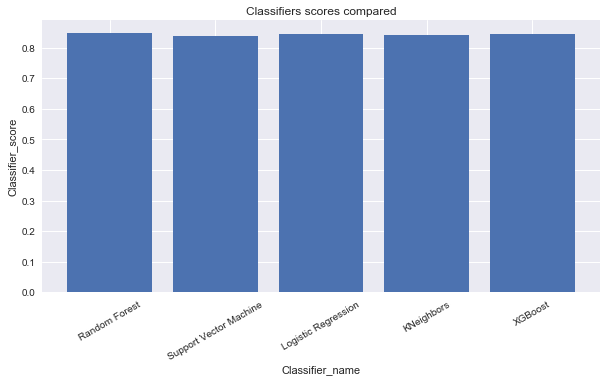

In [16]:
#Plot scores
x_values=scores_df['Classifier_name']
y_values=scores_df['Classifier_score']
plt.figure(figsize=(10,5))
plt.bar(x_values, y_values, label="Classifiers")
plt.xlabel('Classifier_name')
plt.xticks( scores_df['Classifier_name'], rotation=30) 
plt.ylabel("Classifier_score")
plt.title('Classifiers scores compared')
plt.show()

In [17]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(df['Clean_tweet'], df['Sentiment'], test_size = 0.20, random_state = 100)

'fit_on_texts' -  Updates internal vocabulary based on a list of texts. This method creates the vocabulary index based on word frequency. So if you give it something like, "The cat sat on the mat." It will create a dictionary s.t. word_index["the"] = 1; word_index["cat"] = 2 it is word -> index dictionary so every word gets a unique integer value. 0 is reserved for padding. So lower integer means more frequent word (often the first few are stop words because they appear a lot).

'texts_to_sequences' -  Transforms each text in texts to a sequence of integers. So it basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary. 

'pad_sequences' - This function transforms a list of num_samples sequences (lists of integers) into a matrix of shape (num_samples, num_timesteps). num_timesteps is either the maxlen argument if provided, or the length of the longest sequence otherwise.

Sequences that are shorter than num_timesteps are padded with value at the end.

Sequences longer than num_timesteps are truncated so that they fit the desired length. The position where padding or truncation happens is determined by the arguments padding and truncating, respectively.

In [18]:
# Tokenization
#limit vocabulary to 2000.
tokenizer = Tokenizer(num_words = 2000, split = ' ')
tokenizer.fit_on_texts(X_train.astype(str).values)
train_tweets = tokenizer.texts_to_sequences(X_train.astype(str).values)
max_len = max([len(i) for i in train_tweets])
train_tweets = pad_sequences(train_tweets, maxlen = max_len)
test_tweets = tokenizer.texts_to_sequences(X_test.astype(str).values)
test_tweets = pad_sequences(test_tweets, maxlen = max_len)

In [19]:
test_tweets

array([[   0,    0,    0, ...,    8,   41,    3],
       [   0,    0,    0, ..., 1133,   39,    9],
       [   0,    0,    0, ...,   49,    1,  663],
       ...,
       [   0,    0,    0, ...,  770,  142,    1],
       [   0,    0,    0, ...,   46,  576,   18],
       [   0,    0,    0, ...,  403,  743,    3]], dtype=int32)

In [20]:
#construct the neural network
model = Sequential()
model.add(Embedding(2000, 128, input_length = train_tweets.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(256, dropout = 0.2))
model.add(Dense(2, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 128)           256000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 20, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               394240    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 650,754
Trainable params: 650,754
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Training the model
history = model.fit(train_tweets, pd.get_dummies(y_train).values, epochs = 10, batch_size = 128, validation_split = 0.2)

Train on 2264 samples, validate on 567 samples
Epoch 1/10
2264/2264 [==============================] - 2s 981us/step - loss: 0.5155 - acc: 0.8136 - val_loss: 0.4131 - val_acc: 0.8519
Epoch 2/10
2264/2264 [==============================] - 2s 701us/step - loss: 0.4176 - acc: 0.8344 - val_loss: 0.3764 - val_acc: 0.8519
Epoch 3/10
2264/2264 [==============================] - 2s 681us/step - loss: 0.3452 - acc: 0.8410 - val_loss: 0.2908 - val_acc: 0.8801
Epoch 4/10
2264/2264 [==============================] - 2s 676us/step - loss: 0.2388 - acc: 0.9037 - val_loss: 0.3009 - val_acc: 0.8818
Epoch 5/10
2264/2264 [==============================] - 1s 657us/step - loss: 0.1831 - acc: 0.9302 - val_loss: 0.2950 - val_acc: 0.8942
Epoch 6/10
2264/2264 [==============================] - 2s 705us/step - loss: 0.1397 - acc: 0.9342 - val_loss: 0.3575 - val_acc: 0.8871
Epoch 7/10
2264/2264 [==============================] - 2s 693us/step - loss: 0.1045 - acc: 0.9580 - val_loss: 0.3805 - val_acc: 0.8801
E

In [22]:
# Testing the model
score, accuracy = model.evaluate(test_tweets, pd.get_dummies(y_test).values, batch_size = 128)
print("Test accuracy: {0:.6f}".format(accuracy))


708/708 [==============================] - 0s 187us/step
Test accuracy: 0.850282


In [23]:
#add row in score df
keras_row= {'Classifier_name': 'Keras model','Classifier_score': "{0:.6f}".format(accuracy)}
#append row to the dataframe
scores_df = scores_df.append(keras_row, ignore_index=True)

In [24]:
#turn classifier score column into numeric data
scores_df['Classifier_score'] = pd.to_numeric(scores_df['Classifier_score'], errors='ignore')

In [25]:
scores_df

,Classifier_name,Classifier_score
0,Random Forest,0.846567
1,Support Vector Machine,0.839220
2,Logistic Regression,0.844308
3,KNeighbors,0.841766
4,XGBoost,0.845155
5,Keras model,0.850282


In [26]:
#get the best performing model
y = max(scores_df['Classifier_score'])
y        

0.850282

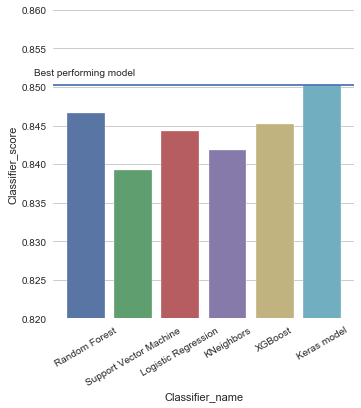

In [49]:
#Plot scores using seaborn
g = sns.catplot(x='Classifier_name', y='Classifier_score', kind = 'bar', data = scores_df)
g.set_xticklabels(rotation=30)
ax=plt.gca()  
ax.axhline(y= y)
plt.ylim(0.82, 0.86)
plt.scatter(0, y, marker='', s=100)
plt.annotate('Best performing model', # this is the text
            (0,y), # this is the point to label
            textcoords="offset points", # how to position the text
            xytext=(-1,10), # distance from text to points (x,y)
            ha='center') # horizontal alignment can be left, right or center
plt.savefig('best_classifier.png')

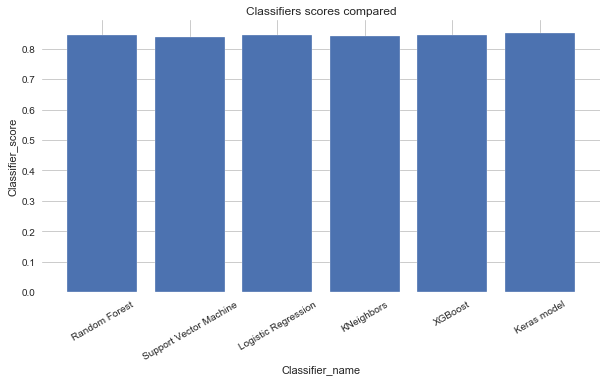

In [29]:
x_values=scores_df["Classifier_name"]
y_values=scores_df['Classifier_score']
plt.figure(figsize=(10,5))
plt.bar(x_values, y_values, label="Classifiers")
plt.xlabel('Classifier_name')
plt.xticks( scores_df['Classifier_name'], rotation=30) 
plt.ylabel("Classifier_score")
plt.title('Classifiers scores compared')
plt.show()